<a href="https://www.kaggle.com/code/mohdmuttalib/spine-fracture-detection-project-eda?scriptVersionId=135828381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Import libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os
import re
import gc
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pprint import pprint
import nibabel as nib
from glob import glob

# 2. Load the CSV files in the dataset:

In [2]:
# Load csv files
train_df = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train.csv')
train_bbox = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')

In [3]:
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [4]:
train_bbox.head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


In [5]:
# Get the list of verterbraes
verterbraes = list(train_df.columns[-7:])
verterbraes

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

In [6]:
print('Number of patients in the training dataset:', len(train_df.StudyInstanceUID.unique()))

Number of patients in the training dataset: 2019


In [7]:
train_df.describe()

,patient_overall,C1,C2,C3,C4,C5,C6,C7
count,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000
mean,0.475978,0.072313,0.141159,0.036157,0.053492,0.080238,0.137197,0.194651
std,0.499546,0.259070,0.348272,0.186726,0.225068,0.271728,0.344140,0.396030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This dataset's statistics depicts some following information:

This dataset is nearly balanced (as nearly 50% of patients have fractures).
Fractures in C3 have the lowest percentage (about 3.6%), and fractures in C7 have the highest one (nearly 19.5%).

# 3. EDA for training dataset:

#a. Overview analysis of training dataset:

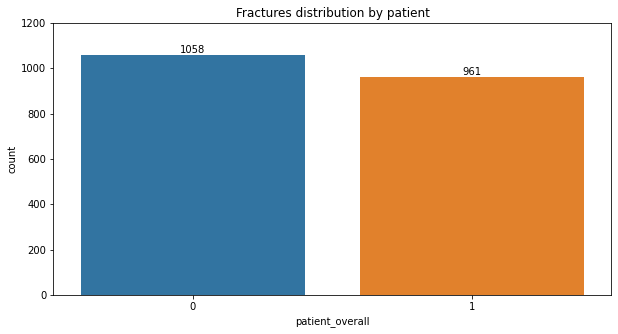

In [8]:
plt.figure(figsize=(10, 5))
ax1 = sns.countplot(x='patient_overall', data=train_df)
for container in ax1.containers:
    ax1.bar_label(container)
plt.title('Fractures distribution by patient')
plt.ylim([0, 1200])
plt.show()

In [9]:
train_melt = pd.melt(train_df, id_vars=['StudyInstanceUID', 'patient_overall'],
                     value_vars=verterbraes, var_name='verterbrae', value_name='fractured')
train_melt.head(10)

,StudyInstanceUID,patient_overall,verterbrae,fractured
0,1.2.826.0.1.3680043.6200,1,C1,1
1,1.2.826.0.1.3680043.27262,1,C1,0
2,1.2.826.0.1.3680043.21561,1,C1,0
3,1.2.826.0.1.3680043.12351,0,C1,0
4,1.2.826.0.1.3680043.1363,1,C1,0
5,1.2.826.0.1.3680043.4859,1,C1,0
6,1.2.826.0.1.3680043.18659,1,C1,0
7,1.2.826.0.1.3680043.17364,0,C1,0
8,1.2.826.0.1.3680043.849,0,C1,0
9,1.2.826.0.1.3680043.24045,1,C1,0


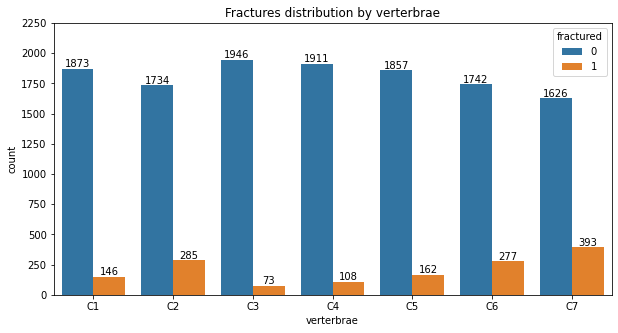

In [10]:
plt.figure(figsize=(10, 5))
ax2 = sns.countplot(x='verterbrae', hue='fractured', data=train_melt)
for container in ax2.containers:
    ax2.bar_label(container)
plt.title('Fractures distribution by verterbrae')
plt.ylim([0, 2250])
plt.show()

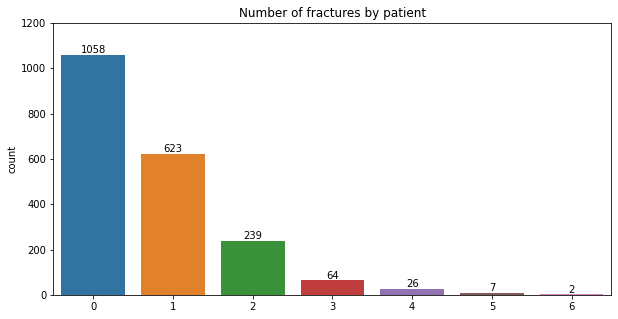

In [11]:
plt.figure(figsize=(10, 5))
ax3 = sns.countplot(x=train_df[verterbraes].sum(axis=1))
for container in ax3.containers:
    ax3.bar_label(container)
plt.title('Number of fractures by patient')
plt.ylim([0, 1200])
plt.show()

Most of fractured patients have only fractures on 1 verterbrae.

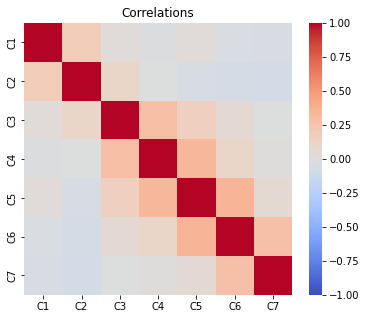

In [12]:
plt.figure(figsize=(6, 5))
sns.heatmap(train_df[verterbraes].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlations')
plt.show()

This correlation indicates that patients, who has fracture in an any verterbrae, may have another fracture in an adjacent verterbrae.

# b. Visualization of several image samples:

In [13]:
# Load some sample images in the dataset
sample_path = '../input/rsna-2022-cervical-spine-fracture-detection/train_images/1.2.826.0.1.3680043.10921/15.dcm'
sample_dcm = pydicom.dcmread(sample_path)
sample_dcm

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10921.1.15
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.3.0'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.10921.1.15
(0008, 0023) Content Date                        DA: '20220727'
(0008, 0033) Content Time                        TM: '182438.486552'
(0010, 0010) Patient's Name                      PN: '10921'
(0010, 0020) Patient ID                          LO: '10921'
(0018, 0050) Slice Thickness                     DS: '0.625'
(0020, 000d) Study Instance UID                  UI: 1.2.826.0

In [14]:
# Extract image from sample DCM metadata
image = apply_voi_lut(sample_dcm.pixel_array, sample_dcm)

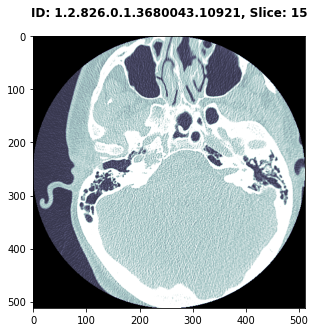

In [15]:
# Visualize the sample image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='bone')
plt.title('ID: 1.2.826.0.1.3680043.10921, Slice: 15', weight='bold', size=12, y=1.05)
plt.show()

In [16]:
# Visualize 15 images of a case
def visualize_15_images(instance_uid):
    dcm_paths = [f'../input/rsna-2022-cervical-spine-fracture-detection/train_images/{instance_uid}/{i+100}.dcm' for i in range(15)]
    dcm_files = [pydicom.dcmread(path) for path in dcm_paths]
    images = [apply_voi_lut(file.pixel_array, file) for file in dcm_files]
    fig, ax = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle(f'ID: {instance_uid}', weight='bold', size=20)
    for i in range(15):
        image = images[i]
        row = i // 5
        col = i % 5
        ax[row, col].imshow(image, cmap='bone')
        ax[row, col].set_title(f'Slice no: {i+100}', size=14)
        ax[row, col].axis('off')
    plt.show()

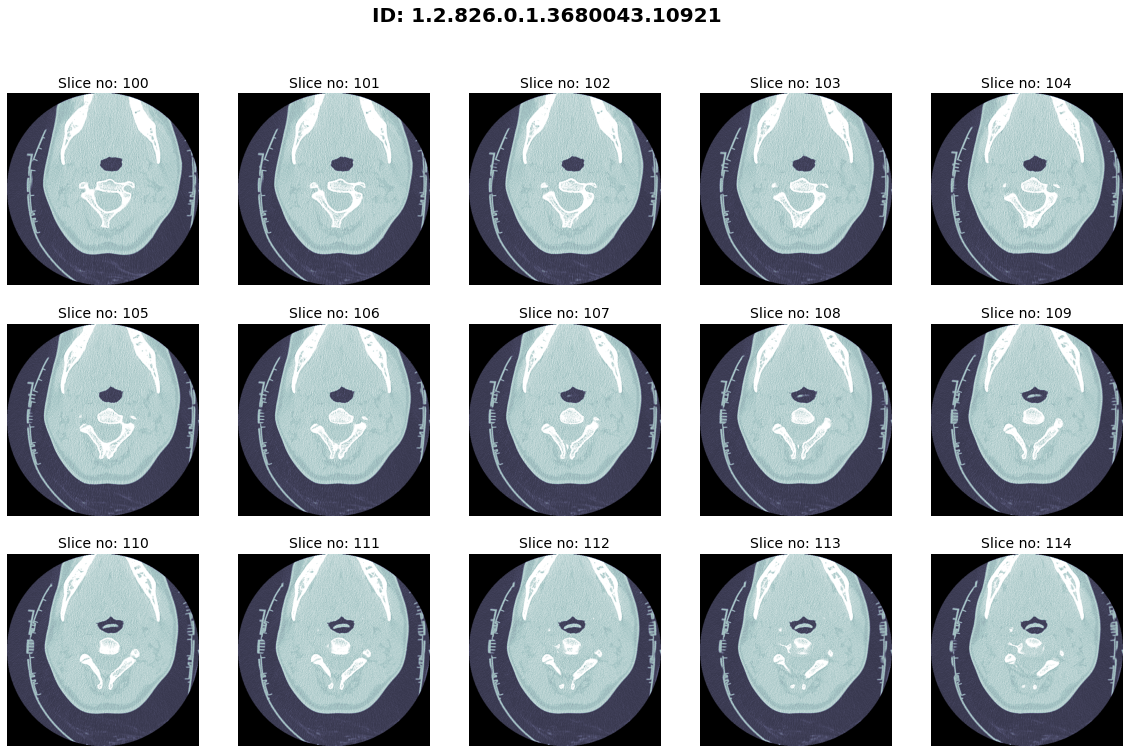

In [17]:
visualize_15_images('1.2.826.0.1.3680043.10921')

# c. Visualization of several segmented masks:

In [18]:
# Load some segmented masks
sample_mask_path = '../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.10921.nii'
sample_nii = nib.load(sample_mask_path)
sample_nii

In [19]:
sample_seg = sample_nii.get_fdata()[:, ::-1, ::-1].transpose([2, 1, 0])
sample_seg.shape

(339, 512, 512)

In [20]:
# Visualize 15 masks of an instance (patient)
def visualize_15_masks(instance_uid):
    mask_path = f'../input/rsna-2022-cervical-spine-fracture-detection/segmentations/{instance_uid}.nii'
    nii_data = nib.load(mask_path)
    seg_masks = nii_data.get_fdata()[:, ::-1, ::-1].transpose([2, 1, 0])
    fig, ax = plt.subplots(3, 5, figsize=(20, 12))
    fig.suptitle(f'ID: {instance_uid}', weight='bold', size=20)
    for i in range(15):
        row = i // 5
        col = i % 5
        mask = seg_masks[i+100]
        ax[row, col].imshow(mask, cmap='inferno')
        ax[row, col].set_title(f'Slice: {i+100}', size=14)
        ax[row, col].axis('off')
    plt.show()

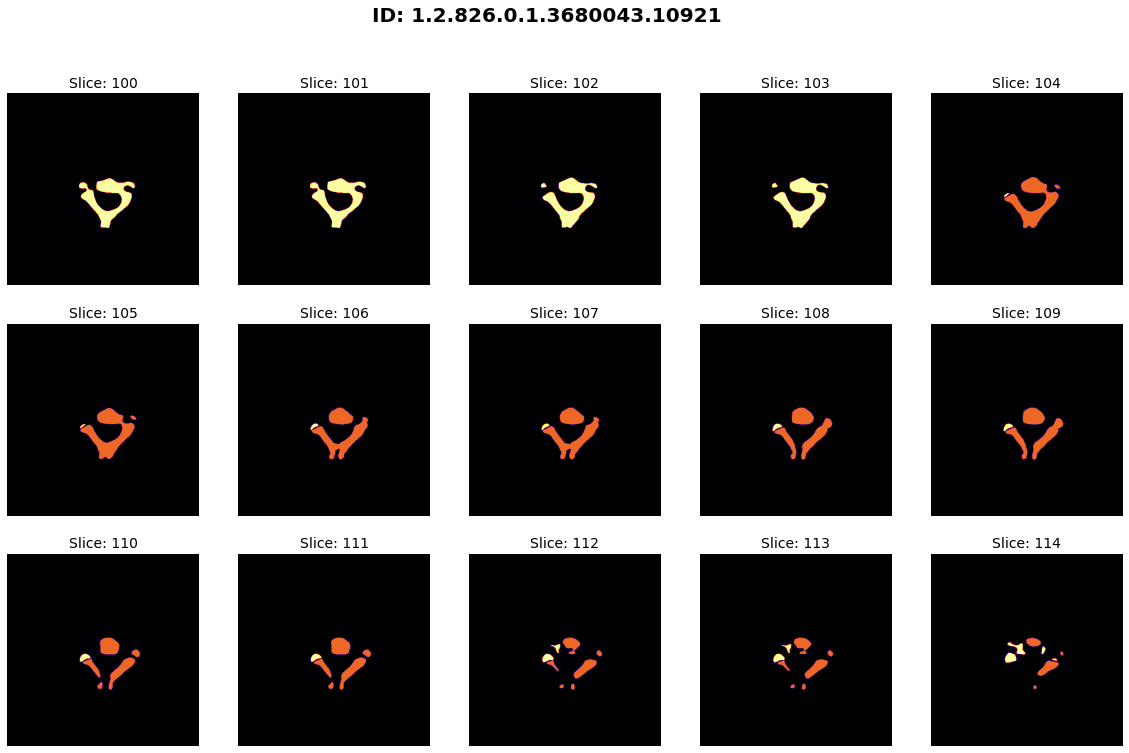

In [21]:
visualize_15_masks('1.2.826.0.1.3680043.10921')

In [22]:
print('Number of cases that have segmentations:', len(glob('../input/rsna-2022-cervical-spine-fracture-detection/segmentations/*')))

Number of cases that have segmentations: 87


Number of cases that have segmentations: 87

# 4. EDA for training set with bounding boxes:

a. Overview analysis of training set with bounding boxes:

In [23]:
# Get training with bounding boxes data
train_bbox.head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


In [24]:
print('Number of cases with bounding boxes:', len(train_bbox.StudyInstanceUID.unique()))

Number of cases with bounding boxes: 235


Only 235 cases (out of 2019 cases), equivalent to 11.64% of all cases, have bounding boxes on their CT images.

In [25]:
train_df_bbox = train_df[train_df.StudyInstanceUID.isin(train_bbox.StudyInstanceUID)]
train_df_bbox.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
10,1.2.826.0.1.3680043.4744,1,0,0,0,1,1,0,0
14,1.2.826.0.1.3680043.5482,1,1,0,0,0,0,0,0
23,1.2.826.0.1.3680043.9447,1,0,1,0,0,0,0,0


In [26]:
train_df_bbox.describe()

,patient_overall,C1,C2,C3,C4,C5,C6,C7
count,235.0,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,1.0,0.195745,0.272340,0.208511,0.272340,0.314894,0.370213,0.344681
std,0.0,0.397620,0.446114,0.407111,0.446114,0.465465,0.483892,0.476279
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All of cases which have bounding boxes are fractured.
C1-typed fractures have the lowest bounding box rate (only 19.57%), and C6-typed ones have the highest bounding box rate (just over 37%).

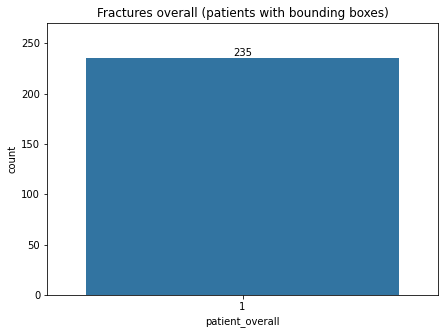

In [27]:
plt.figure(figsize=(7, 5))
ax4 = sns.countplot(x='patient_overall', data=train_df_bbox)
for container in ax4.containers:
    ax4.bar_label(container)
plt.title('Fractures overall (patients with bounding boxes)')
plt.ylim([0, 270])
plt.show()

In [28]:
train_df_bbox_melt = pd.melt(train_df_bbox, id_vars=['StudyInstanceUID', 'patient_overall'],
                             var_name='cervical_verterbrae', value_name='fractured')
train_df_bbox_melt.head(10)

,StudyInstanceUID,patient_overall,cervical_verterbrae,fractured
0,1.2.826.0.1.3680043.21561,1,C1,0
1,1.2.826.0.1.3680043.1363,1,C1,0
2,1.2.826.0.1.3680043.4744,1,C1,0
3,1.2.826.0.1.3680043.5482,1,C1,1
4,1.2.826.0.1.3680043.9447,1,C1,0
5,1.2.826.0.1.3680043.4561,1,C1,0
6,1.2.826.0.1.3680043.28657,1,C1,0
7,1.2.826.0.1.3680043.29548,1,C1,0
8,1.2.826.0.1.3680043.21586,1,C1,1
9,1.2.826.0.1.3680043.25435,1,C1,0


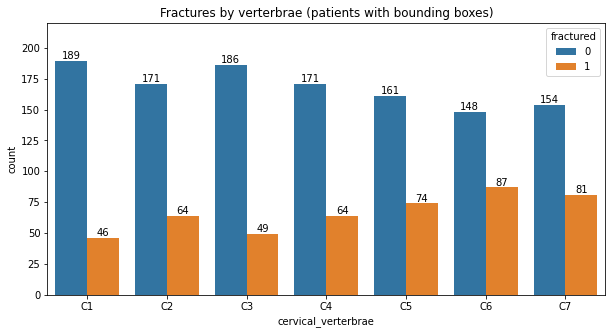

In [29]:
plt.figure(figsize=(10, 5))
ax5 = sns.countplot(x='cervical_verterbrae', hue='fractured', data=train_df_bbox_melt)
for container in ax5.containers:
    ax5.bar_label(container)
plt.title('Fractures by verterbrae (patients with bounding boxes)')
plt.ylim([0, 220])
plt.show()

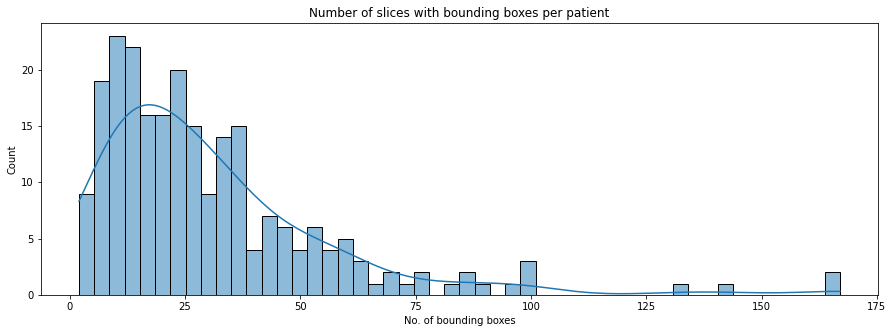

In [30]:
plt.figure(figsize=(15, 5))
sns.histplot(train_bbox.StudyInstanceUID.value_counts().values, kde=True, bins=50)
plt.title('Number of slices with bounding boxes per patient')
plt.xlabel('No. of bounding boxes')
plt.show()

Most of the cases, which have bounding box measurement, have 10 - 35 image slices which contain bounding boxes.

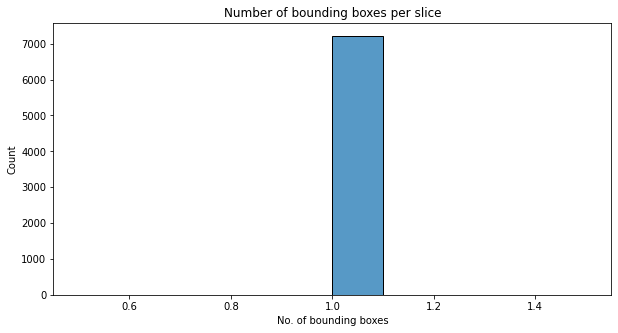

In [31]:
plt.figure(figsize=(10, 5))
sns.histplot(train_bbox[['StudyInstanceUID', 'slice_number']].value_counts().values, bins=10)
plt.title('Number of bounding boxes per slice')
plt.xlabel('No. of bounding boxes')
plt.show()

There is only 1 bounding box for every slice which have bounding box measurements.